## Coursera IBM Data Science Capstone Project

By Tamela Maciel, June 2020

This jupyter notebook completes Coursera's IBM Data Science Professional Certificate capstone project.

It uses the Foursquare API, BeautifulSoup for webscraping, and various python libraries to gather location data for the city of Toronto and compares and clusters various neighborhoods using K-Means.

![alt text](https://raw.githubusercontent.com/tamelamaciel/Coursera_Capstone/master/Toronto%20neighbourhood%20clusters.png "Toronto cluster map")

### Import libraries

In [1]:
import pandas as pd  #database wrangling
import numpy as np #linear algebra
import string
from bs4 import BeautifulSoup #webscraping

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import requests # library to handle requests

import geocoder # convert a postcode into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

### Part 1 - Create Database of Toronto Neighborhoods
Use BeautifulSoup to scrape postcodes, boroughs, and neighborhoods from this wikipedia table:
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Step 1. Request html from the website url

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)
soup = BeautifulSoup(response.text)

Step 2. Find the first table in the html items

In [3]:
table = soup.find('table')

Step 3. Iterate through rows of table (denoted by 'tr' tags), and append to 'neighborhood_df' dataframe if the borough is assigned a name

In [4]:
#create empty dataframe 
column_names=['PostalCode','Borough','Neighborhood']
neighborhood_df = pd.DataFrame(columns=column_names) 

#read in data using table and get_text() functions from Beautiful Soup
row_id = 0
for row in table.find_all('tr'):
    columns = row.find_all('td')
    try:
        postcode=columns[0].get_text().rstrip('\n')
        borough=columns[1].get_text().rstrip('\n')
        neighborhood=columns[2].get_text().rstrip('\n')
        #print(repr(postcode), repr(borough),neighborhood)
        if borough!='Not assigned':
            neighborhood_df = neighborhood_df.append({'PostalCode': postcode,
                                                      'Borough':borough,
                                                      'Neighborhood': neighborhood
                                                     }, ignore_index=True)
    except:
        pass
    row_id += 1

neighborhood_df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [5]:
print("There are {} rows in the 'neighborhoods_df' database".format(neighborhood_df.shape[0]))

There are 103 rows in the 'neighborhoods_df' database


### Part 2 - Get neighborhood lat, long using geocoder

After quite a lot of trial and error with geocoder as well as geopy.geocoders, I'm unable to consistently get lat and long data points for all neighborhoods. Most post codes repeatedly return 'None'.

So will read in csv file instead

In [6]:
### OLD CODE
#postal_code='M1B'
## initialize your variable to None
#lat_lng_coords = None
#
## loop until you get the coordinates
##while(lat_lng_coords is None):
#g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#lat_lng_coords = g.latlng
#
#latitude = lat_lng_coords[0]
#longitude = lat_lng_coords[1]
#print(latitude,longitude)

In [7]:
lat_lng_file=pd.read_csv("Geospatial_Coordinates.csv")

In [8]:
lat_lng_file=lat_lng_file.rename(columns={'Postal Code':'PostalCode'})
lat_lng_file.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
neighborhood_df=neighborhood_df.merge(lat_lng_file, on="PostalCode")
neighborhood_df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [10]:
print("There are now {} rows and {} columns in the 'neighborhoods_df' database".format(neighborhood_df.shape[0],neighborhood_df.shape[1]))

There are now 103 rows and 5 columns in the 'neighborhoods_df' database


### Part 3 - Cluster neighborhoods by type of venue using foursquare API and k-means

**Step 1 - define client IDs for Foursquare API**

In [11]:
CLIENT_ID = 'LRZS1Q1R12WGF52OQPOSHLS4CC3NNRZYTSKECAHUTTYW0TMR' # your Foursquare ID
CLIENT_SECRET = 'SYHT1RYKRHP5VV3ARJC01GTXMM0ERHOLZXGPL4TYGOPHS1PB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LRZS1Q1R12WGF52OQPOSHLS4CC3NNRZYTSKECAHUTTYW0TMR
CLIENT_SECRET:SYHT1RYKRHP5VV3ARJC01GTXMM0ERHOLZXGPL4TYGOPHS1PB


**Step 2 - get venues around each distinct postcode.**  

Since the postcodes are unique to the boroughs and not the neighborhoods (some boroughs contain more than one neighborhood, but the same postcode for all), we can only gather venue info and cluster over boroughs. 

I include all 103 boroughs in my cluster analysis.

For boroughs that have the same name but different postcodes, I will distingish between them by appending the post code, e.g. 'Downtown Toronto - M5G'. These will be called 'areas' in the resulting database.

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
# function to get max 100 nearby venues within 500 metres of neighborhood lat, long
def getNearbyVenues(boroughs, postcodes, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for borough, postcode, lat, lng in zip(boroughs, postcodes, latitudes, longitudes):
        name=borough+' - '+postcode
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
raw_venues = getNearbyVenues(boroughs=neighborhood_df['Borough'],
                                   postcodes=neighborhood_df['PostalCode'],
                                   latitudes=neighborhood_df['Latitude'],
                                   longitudes=neighborhood_df['Longitude']
                                  )
raw_venues.head()

North York - M3A
North York - M4A
Downtown Toronto - M5A
North York - M6A
Downtown Toronto - M7A
Etobicoke - M9A
Scarborough - M1B
North York - M3B
East York - M4B
Downtown Toronto - M5B
North York - M6B
Etobicoke - M9B
Scarborough - M1C
North York - M3C
East York - M4C
Downtown Toronto - M5C
York - M6C
Etobicoke - M9C
Scarborough - M1E
East Toronto - M4E
Downtown Toronto - M5E
York - M6E
Scarborough - M1G
East York - M4G
Downtown Toronto - M5G
Downtown Toronto - M6G
Scarborough - M1H
North York - M2H
North York - M3H
East York - M4H
Downtown Toronto - M5H
West Toronto - M6H
Scarborough - M1J
North York - M2J
North York - M3J
East York - M4J
Downtown Toronto - M5J
West Toronto - M6J
Scarborough - M1K
North York - M2K
North York - M3K
East Toronto - M4K
Downtown Toronto - M5K
West Toronto - M6K
Scarborough - M1L
North York - M2L
North York - M3L
East Toronto - M4L
Downtown Toronto - M5L
North York - M6L
North York - M9L
Scarborough - M1M
North York - M2M
North York - M3M
East Toronto - 

,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York - M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,North York - M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,North York - M3A,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,North York - M4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,North York - M4A,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


**Step 3 - explore and wrangle venue data so that it's ready to cluster**

In [15]:
print(raw_venues.shape)
raw_venues.head()

(2129, 7)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York - M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,North York - M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,North York - M3A,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,North York - M4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,North York - M4A,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [16]:
#check how many venues per area
venues_grouped=raw_venues.groupby('Area').count()
venues_grouped.head(20)

,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Area,,,,,,
Central Toronto - M4N,3,3,3,3,3,3
Central Toronto - M4P,8,8,8,8,8,8
Central Toronto - M4R,21,21,21,21,21,21
Central Toronto - M4S,33,33,33,33,33,33
Central Toronto - M4T,4,4,4,4,4,4
Central Toronto - M4V,17,17,17,17,17,17
Central Toronto - M5N,1,1,1,1,1,1
Central Toronto - M5P,5,5,5,5,5,5
Central Toronto - M5R,21,21,21,21,21,21


The number of venues per area varies hugely between 1 and 100. For the purposes of clustering, we'll want to have enough venues to build a profile of an area.

So let's drop all areas that have less than 10 venues.

In [17]:
areas_to_drop=venues_grouped[venues_grouped['Venue']<10].index.tolist()
print(len(areas_to_drop))

52


This results in 52 areas to drop:

In [18]:
toronto_venues=raw_venues.set_index('Area')
toronto_venues=toronto_venues.drop(areas_to_drop,axis=0)
toronto_venues=toronto_venues.reset_index()
print("There are now {} rows and {} columns in the 'toronto_venues' database".format(toronto_venues.shape[0],toronto_venues.shape[1]))

There are now 1912 rows and 7 columns in the 'toronto_venues' database


Let's look at the number of unique venue categories across all areas.

In [19]:
print('There are {} unique venue categories in Toronto'.format(len(toronto_venues['Venue Category'].unique())))

There are 250 unique venue categories in Toronto


Now set up the database for clustering and analysis.  
First, use one-hot encoding for all unique venue categories, in a new database that includes the area name.

In [20]:
## one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

## add area column back to dataframe
toronto_onehot['Area'] = toronto_venues['Area'] 

## move area column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Area,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Downtown Toronto - M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Downtown Toronto - M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Downtown Toronto - M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Downtown Toronto - M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Downtown Toronto - M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, group by area name and take the mean frequency of each type of venue category.

In [21]:
toronto_grouped = toronto_onehot.groupby('Area').mean().reset_index()
toronto_grouped

,Area,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Central Toronto - M4R,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.047619
1,Central Toronto - M4S,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.000000
2,Central Toronto - M4V,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,...,0.00,0.000000,0.000000,0.058824,0.00,0.000000,0.0000,0.000000,0.000000,0.000000
3,Central Toronto - M5R,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.047619,0.000000,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.000000
4,Downtown Toronto - M4X,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.000000
5,Downtown Toronto - M4Y,0.000000,0.0125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012500,...,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.0125,0.012500,0.000000,0.025000
6,Downtown Toronto - M5A,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.021739
7,Downtown Toronto - M5B,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.010000,0.010000,0.00,0.000000,0.0000,0.000000,0.000000,0.000000
8,Downtown Toronto - M5C,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037975,...,0.00,0.012658,0.000000,0.000000,0.00,0.012658,0.0000,0.000000,0.000000,0.000000
9,Downtown Toronto - M5E,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.017857,0.000000,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.000000


In [22]:
toronto_grouped.shape

(47, 251)

The size of the grouped database has the expected number of venue category columns (250) plus 1 area column. It contains 47 unique areas (after dropping the areas that contained less than 10 venues within 500 metres of their lat/long.

Now, let's inspect the top 5 most common venues per area:

In [23]:
num_top_venues = 5

for area in toronto_grouped['Area']:
    print("----"+area+"----")
    temp = toronto_grouped[toronto_grouped['Area'] == area].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Central Toronto - M4R----
                 venue  freq
0          Coffee Shop  0.10
1       Clothing Store  0.10
2          Yoga Studio  0.05
3  Sporting Goods Shop  0.05
4            Pet Store  0.05


----Central Toronto - M4S----
                venue  freq
0      Sandwich Place  0.09
1        Dessert Shop  0.09
2  Italian Restaurant  0.06
3                Café  0.06
4         Pizza Place  0.06


----Central Toronto - M4V----
                venue  freq
0                 Pub  0.12
1         Coffee Shop  0.12
2        Liquor Store  0.06
3          Sports Bar  0.06
4  Light Rail Station  0.06


----Central Toronto - M5R----
            venue  freq
0  Sandwich Place  0.14
1            Café  0.14
2     Coffee Shop  0.10
3  History Museum  0.05
4       BBQ Joint  0.05


----Downtown Toronto - M4X----
         venue  freq
0  Coffee Shop  0.09
1         Café  0.07
2          Pub  0.04
3   Restaurant  0.04
4  Pizza Place  0.04


----Downtown Toronto - M4Y----
                 venue  freq

At a quick glance, we can already begin to see key differences in the common venues per area. For example, 'Downtown Toronto - M5V' clearly contains an airport as it's three most common venues are 'Airport Service','Airport Lounge', and 'Airport Terminal'. A quick google confirms that this is the 'Billy Bishop Toronto Airport' on Centre Islands.

But let's cluster and profile these more methodically.

First, we'll create a new database with the top 10 most common types of venues per area:

In [24]:
#function to return most common venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to designated number of top venues, with appropriate prefixes
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
area_venues_sorted = pd.DataFrame(columns=columns)
area_venues_sorted['Area'] = toronto_grouped['Area']

for ind in np.arange(toronto_grouped.shape[0]):
    area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

area_venues_sorted

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto - M4R,Clothing Store,Coffee Shop,Gym / Fitness Center,Health & Beauty Service,Italian Restaurant,Fast Food Restaurant,Diner,Mexican Restaurant,Cosmetics Shop,Sporting Goods Shop
1,Central Toronto - M4S,Dessert Shop,Sandwich Place,Café,Italian Restaurant,Coffee Shop,Gym,Sushi Restaurant,Pizza Place,Thai Restaurant,Indian Restaurant
2,Central Toronto - M4V,Pub,Coffee Shop,Pizza Place,Liquor Store,Sports Bar,Restaurant,Bank,Supermarket,Bagel Shop,Sushi Restaurant
3,Central Toronto - M5R,Sandwich Place,Café,Coffee Shop,Pub,Pizza Place,Donut Shop,Burger Joint,Middle Eastern Restaurant,Indian Restaurant,BBQ Joint
4,Downtown Toronto - M4X,Coffee Shop,Café,Bakery,Italian Restaurant,Restaurant,Pizza Place,Pub,General Entertainment,Butcher,Beer Store
5,Downtown Toronto - M4Y,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Yoga Studio,Dance Studio,Café,Burger Joint,Bubble Tea Shop
6,Downtown Toronto - M5A,Coffee Shop,Bakery,Park,Pub,Restaurant,Theater,Café,Breakfast Spot,Farmers Market,Distribution Center
7,Downtown Toronto - M5B,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Middle Eastern Restaurant,Italian Restaurant,Japanese Restaurant,Cosmetics Shop,Tea Room,Bookstore
8,Downtown Toronto - M5C,Café,Coffee Shop,Cocktail Bar,Gastropub,American Restaurant,Clothing Store,Cosmetics Shop,Restaurant,Italian Restaurant,Lingerie Store
9,Downtown Toronto - M5E,Coffee Shop,Cocktail Bar,Café,Bakery,Beer Bar,Restaurant,Cheese Shop,Seafood Restaurant,Shopping Mall,Irish Pub


Confirm that this new database contains the correct number of areas and columns

In [26]:
area_venues_sorted.shape

(47, 11)

**Step 4 - cluster using k-means**  
Now that we have a database of Toronto areas along with their top 10 most common venues, we can run a k-means clustering algorithm to segment these areas into clusters.

In [27]:
# set number of clusters - start with 5 initially, but will need to examine inertia of clusters for accuracy
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init="k-means++", random_state=0,n_init=10,algorithm="full").fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 4, 4, 0, 1, 0,
       1, 1, 1], dtype=int32)

From the labels, it appears that cluster 1 is by far the biggest cluster, with only one area in cluster 2 and cluster 3. It might be that k=5 wasn't a good choice of cluster number. We'll need to iterate over a range of k values to check accuracy of the model.

In [28]:
Ks = 10
inertias = np.zeros((Ks-1))

for k in range(1,Ks):
    
    #Run K-Means cluster algorithm and save measure of 'inertia' to list
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0,n_init=10,algorithm="full").fit(toronto_grouped_clustering)
    inertias[k-1] = kmeans.inertia_

inertias

array([2.09434961, 1.91224991, 1.78318677, 1.74141053, 1.62138854,
       1.54330902, 1.46379452, 1.36348461, 1.26027982])

**Step 5 - find best K by plotting inertia and determining 'elbow**

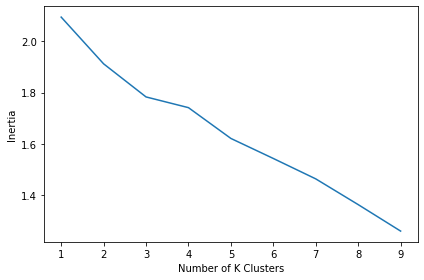

In [29]:
plt.plot(range(1,Ks),inertias)
plt.ylabel('Inertia')
plt.xlabel('Number of K Clusters')
plt.tight_layout()
plt.show()

From this 'elbow method', we first see the rate of decrease of inertia sharply change at K=3, indicating that this is the best number of clusters.

Re-cluster using K=3 to get best clusters for Toronto areas.

In [30]:
# set number of clusters to 3 based on elbow method
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init="k-means++", random_state=0,n_init=10,algorithm="full").fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 0, 1, 1, 1, 1, 2, 2,
       2, 2, 2], dtype=int32)

We still have a range of cluster sizes, even with just 3 clusters. There is only one 'cluster 0'. However, we'll proceed with visualising these clusters to see if their profiles are intuitive.

**Step 6 - wrangle cluster data and map**  
Let's create a database with venue info as well as cluster label, and visualise these on a map.

In [31]:
area_venues_sorted.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto - M4R,Clothing Store,Coffee Shop,Gym / Fitness Center,Health & Beauty Service,Italian Restaurant,Fast Food Restaurant,Diner,Mexican Restaurant,Cosmetics Shop,Sporting Goods Shop
1,Central Toronto - M4S,Dessert Shop,Sandwich Place,Café,Italian Restaurant,Coffee Shop,Gym,Sushi Restaurant,Pizza Place,Thai Restaurant,Indian Restaurant
2,Central Toronto - M4V,Pub,Coffee Shop,Pizza Place,Liquor Store,Sports Bar,Restaurant,Bank,Supermarket,Bagel Shop,Sushi Restaurant
3,Central Toronto - M5R,Sandwich Place,Café,Coffee Shop,Pub,Pizza Place,Donut Shop,Burger Joint,Middle Eastern Restaurant,Indian Restaurant,BBQ Joint
4,Downtown Toronto - M4X,Coffee Shop,Café,Bakery,Italian Restaurant,Restaurant,Pizza Place,Pub,General Entertainment,Butcher,Beer Store


In [32]:
# add clustering labels to toronto venue database
area_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)
area_venues_sorted

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto - M4R,2,Clothing Store,Coffee Shop,Gym / Fitness Center,Health & Beauty Service,Italian Restaurant,Fast Food Restaurant,Diner,Mexican Restaurant,Cosmetics Shop,Sporting Goods Shop
1,Central Toronto - M4S,2,Dessert Shop,Sandwich Place,Café,Italian Restaurant,Coffee Shop,Gym,Sushi Restaurant,Pizza Place,Thai Restaurant,Indian Restaurant
2,Central Toronto - M4V,2,Pub,Coffee Shop,Pizza Place,Liquor Store,Sports Bar,Restaurant,Bank,Supermarket,Bagel Shop,Sushi Restaurant
3,Central Toronto - M5R,2,Sandwich Place,Café,Coffee Shop,Pub,Pizza Place,Donut Shop,Burger Joint,Middle Eastern Restaurant,Indian Restaurant,BBQ Joint
4,Downtown Toronto - M4X,2,Coffee Shop,Café,Bakery,Italian Restaurant,Restaurant,Pizza Place,Pub,General Entertainment,Butcher,Beer Store
5,Downtown Toronto - M4Y,2,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Yoga Studio,Dance Studio,Café,Burger Joint,Bubble Tea Shop
6,Downtown Toronto - M5A,2,Coffee Shop,Bakery,Park,Pub,Restaurant,Theater,Café,Breakfast Spot,Farmers Market,Distribution Center
7,Downtown Toronto - M5B,2,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Middle Eastern Restaurant,Italian Restaurant,Japanese Restaurant,Cosmetics Shop,Tea Room,Bookstore
8,Downtown Toronto - M5C,2,Café,Coffee Shop,Cocktail Bar,Gastropub,American Restaurant,Clothing Store,Cosmetics Shop,Restaurant,Italian Restaurant,Lingerie Store
9,Downtown Toronto - M5E,2,Coffee Shop,Cocktail Bar,Café,Bakery,Beer Bar,Restaurant,Cheese Shop,Seafood Restaurant,Shopping Mall,Irish Pub


Then create a final merged database that includes top 10 venues, cluster label, and lat/long for each area (for mapping)


In [33]:
#get the area lat and long data from the 'raw_venues' database, grouped by Area. 
#The mean lat/long for each distinct area is simply the same as its original lat/long.
area_latlong=raw_venues.groupby('Area').mean().reset_index()
area_latlong=area_latlong.drop(['Venue Latitude','Venue Longitude'],axis=1)
area_latlong

,Area,Area Latitude,Area Longitude
0,Central Toronto - M4N,43.728020,-79.388790
1,Central Toronto - M4P,43.712751,-79.390197
2,Central Toronto - M4R,43.715383,-79.405678
3,Central Toronto - M4S,43.704324,-79.388790
4,Central Toronto - M4T,43.689574,-79.383160
...,...,...,...
94,York - M6C,43.693781,-79.428191
95,York - M6E,43.689026,-79.453512
96,York - M6M,43.691116,-79.476013
97,York - M6N,43.673185,-79.487262


Merge area_venues_sorted with area_latlong database. 
Since we dropped a number of areas due to <10 venues, we do a left join here to keep only the keys of 'area_venues_sorted'

In [34]:
toronto_merged = pd.merge(area_venues_sorted,area_latlong,on='Area',how='left')
toronto_merged

,Area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Area Latitude,Area Longitude
0,Central Toronto - M4R,2,Clothing Store,Coffee Shop,Gym / Fitness Center,Health & Beauty Service,Italian Restaurant,Fast Food Restaurant,Diner,Mexican Restaurant,Cosmetics Shop,Sporting Goods Shop,43.715383,-79.405678
1,Central Toronto - M4S,2,Dessert Shop,Sandwich Place,Café,Italian Restaurant,Coffee Shop,Gym,Sushi Restaurant,Pizza Place,Thai Restaurant,Indian Restaurant,43.704324,-79.388790
2,Central Toronto - M4V,2,Pub,Coffee Shop,Pizza Place,Liquor Store,Sports Bar,Restaurant,Bank,Supermarket,Bagel Shop,Sushi Restaurant,43.686412,-79.400049
3,Central Toronto - M5R,2,Sandwich Place,Café,Coffee Shop,Pub,Pizza Place,Donut Shop,Burger Joint,Middle Eastern Restaurant,Indian Restaurant,BBQ Joint,43.672710,-79.405678
4,Downtown Toronto - M4X,2,Coffee Shop,Café,Bakery,Italian Restaurant,Restaurant,Pizza Place,Pub,General Entertainment,Butcher,Beer Store,43.667967,-79.367675
5,Downtown Toronto - M4Y,2,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Yoga Studio,Dance Studio,Café,Burger Joint,Bubble Tea Shop,43.665860,-79.383160
6,Downtown Toronto - M5A,2,Coffee Shop,Bakery,Park,Pub,Restaurant,Theater,Café,Breakfast Spot,Farmers Market,Distribution Center,43.654260,-79.360636
7,Downtown Toronto - M5B,2,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Middle Eastern Restaurant,Italian Restaurant,Japanese Restaurant,Cosmetics Shop,Tea Room,Bookstore,43.657162,-79.378937
8,Downtown Toronto - M5C,2,Café,Coffee Shop,Cocktail Bar,Gastropub,American Restaurant,Clothing Store,Cosmetics Shop,Restaurant,Italian Restaurant,Lingerie Store,43.651494,-79.375418
9,Downtown Toronto - M5E,2,Coffee Shop,Cocktail Bar,Café,Bakery,Beer Bar,Restaurant,Cheese Shop,Seafood Restaurant,Shopping Mall,Irish Pub,43.644771,-79.373306


In [35]:
# create map
toronto_latitude = 43.6600
toronto_longitude = -79.3832

map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Area Latitude'], toronto_merged['Area Longitude'], toronto_merged['Area'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Step 7 - profile clusters based on most common venues in each**  
The three clusters broadly differentiate on the most common 1st and 2nd venues in each area. 

I have given them profile names based on my interpretation of these different types of venues, and their location on the map.

### Cluster 0 - Retail shops

In [36]:
cluster0_df=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(2, toronto_merged.shape[1]-2))]]
cluster0_df

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,North York - M6A,Clothing Store,Furniture / Home Store,Accessories Store,Boutique,Gift Shop,Event Space,Miscellaneous Shop,Coffee Shop,Women's Store,Vietnamese Restaurant


In [37]:
cluster0_df.shape

(1, 11)

### Cluster 1 - Suburb Restaurants and Groceries

In [38]:
cluster1_df=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(2, toronto_merged.shape[1]-2))]]
cluster1_df

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,East York - M4B,Pizza Place,Gym / Fitness Center,Gastropub,Pharmacy,Café,Breakfast Spot,Bank,Intersection,Athletics & Sports,Fast Food Restaurant
28,East York - M4H,Indian Restaurant,Yoga Studio,Discount Store,Supermarket,Restaurant,Liquor Store,Bus Line,Fast Food Restaurant,Burger Joint,Pizza Place
30,Etobicoke - M8Z,Grocery Store,Convenience Store,Bakery,Tanning Salon,Burrito Place,Burger Joint,Sandwich Place,Supplement Shop,Kids Store,Hardware Store
35,North York - M3H,Coffee Shop,Bank,Gift Shop,Fried Chicken Joint,Bridal Shop,Sandwich Place,Diner,Restaurant,Deli / Bodega,Supermarket
38,Scarborough - M1L,Bakery,Bus Line,Soccer Field,Park,Ice Cream Shop,Bus Station,Metro Station,Intersection,Distribution Center,Discount Store
39,Scarborough - M1T,Pharmacy,Pizza Place,Fried Chicken Joint,Gas Station,Bank,Italian Restaurant,Thai Restaurant,Chinese Restaurant,Intersection,Convenience Store
40,Scarborough - M1W,Grocery Store,Chinese Restaurant,Bank,Fast Food Restaurant,Electronics Store,Pharmacy,Pizza Place,Sandwich Place,Breakfast Spot,Coffee Shop
41,West Toronto - M6H,Bakery,Pharmacy,Park,Middle Eastern Restaurant,Music Venue,Pet Store,Pizza Place,Café,Brewery,Bar


In [39]:
cluster1_df.shape

(8, 11)

### Cluster 2 - Downtown Cafes and Fast Food

In [40]:
cluster2_df=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(2, toronto_merged.shape[1]-2))]]
cluster2_df

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto - M4R,Clothing Store,Coffee Shop,Gym / Fitness Center,Health & Beauty Service,Italian Restaurant,Fast Food Restaurant,Diner,Mexican Restaurant,Cosmetics Shop,Sporting Goods Shop
1,Central Toronto - M4S,Dessert Shop,Sandwich Place,Café,Italian Restaurant,Coffee Shop,Gym,Sushi Restaurant,Pizza Place,Thai Restaurant,Indian Restaurant
2,Central Toronto - M4V,Pub,Coffee Shop,Pizza Place,Liquor Store,Sports Bar,Restaurant,Bank,Supermarket,Bagel Shop,Sushi Restaurant
3,Central Toronto - M5R,Sandwich Place,Café,Coffee Shop,Pub,Pizza Place,Donut Shop,Burger Joint,Middle Eastern Restaurant,Indian Restaurant,BBQ Joint
4,Downtown Toronto - M4X,Coffee Shop,Café,Bakery,Italian Restaurant,Restaurant,Pizza Place,Pub,General Entertainment,Butcher,Beer Store
5,Downtown Toronto - M4Y,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Yoga Studio,Dance Studio,Café,Burger Joint,Bubble Tea Shop
6,Downtown Toronto - M5A,Coffee Shop,Bakery,Park,Pub,Restaurant,Theater,Café,Breakfast Spot,Farmers Market,Distribution Center
7,Downtown Toronto - M5B,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Middle Eastern Restaurant,Italian Restaurant,Japanese Restaurant,Cosmetics Shop,Tea Room,Bookstore
8,Downtown Toronto - M5C,Café,Coffee Shop,Cocktail Bar,Gastropub,American Restaurant,Clothing Store,Cosmetics Shop,Restaurant,Italian Restaurant,Lingerie Store
9,Downtown Toronto - M5E,Coffee Shop,Cocktail Bar,Café,Bakery,Beer Bar,Restaurant,Cheese Shop,Seafood Restaurant,Shopping Mall,Irish Pub


In [41]:
cluster2_df.shape

(38, 11)

**Step 8 - conclusions**

In this notebook, I have segmented and clustered areas of Toronto (Boroughs by Postal Code) into three distinct clusters that can be profiled generally as "Retail shops" (1 area), "Suburb Restaurants and Groceries" (8 areas), and "Downtown Cafes and Fast Food" (38 areas).

The key geographic data was scrapped from a wikipedia table of Toronto boroughs, using BeautifulSoup, and from a csv file of postal codes, latitudes, and longitudes (failing successful geocoder).

The top venues within 500 metres of each area lat/long were gathered using the Foursquare API. In order to build a full profile of each area, I dropped those areas that returned less than 10 venues, as these would be biaised heavily to the small number of venues within.

This left 47 areas to cluster. A K-means algorithm was used to cluster these areas based on the top 10 types of venue per each area. In order to select the best number of clusters, K, I iterated the clustering between 1-10 and selected the value K=3 according to the measure of inertia and the 'elbow method'.

